In [2]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from model import ode_y_damage_ambiguity_conditional, uncertainty_decomposition_damage_ambiguity
from simulation import simulation
from utilities import find_nearest_value
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
ξ_a = .01
# ξ_a = 1000.

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = np.array([0, .0197*2, .3853*2])

y_step = .02
y_grid = np.arange(0., 4., y_step)

model_res_list = []
for γ_2p_i in γ_2p:
    model_paras_i = (η, δ, θ, πc_o, σ_y, ξ_a, γ_1, γ_2, np.array(γ_2p_i), y_bar) 
    model_res_i = ode_y_damage_ambiguity_conditional(y_grid, model_paras_i, v0=None, ϵ=1.,
                      tol=1e-8, max_iter=5_000, print_all=False)
    model_res_list.append(model_res_i)
e_tilde_list = [res['e_tilde'] for res in model_res_list]

Converged. Total iteration 5000: LHS Error: 5.759672942673433e-05; RHS Error 0.00010365683024227135
Converged. Total iteration 1507: LHS Error: 9.965693159585953e-09; RHS Error 0.0004700271744833215
Converged. Total iteration 1621: LHS Error: 9.952300317195295e-09; RHS Error 0.0022788056913070013


In [16]:
et_low, yt_low, _, _ = simulation(y_grid, e_tilde_list[0],
                          np.zeros_like(y_grid),
                          np.zeros((3, len(y_grid))),
                          θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)
et_high, yt_high, _, _ = simulation(y_grid, e_tilde_list[1],
                          np.zeros_like(y_grid),
                          np.zeros((3, len(y_grid))),
                          θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)
et_extreme, yt_extreme, _, _ = simulation(y_grid, e_tilde_list[2],
                          np.zeros_like(y_grid),
                          np.zeros((3, len(y_grid))),
                          θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)

Text(0.5, 1.0, 'Emission trajectory')

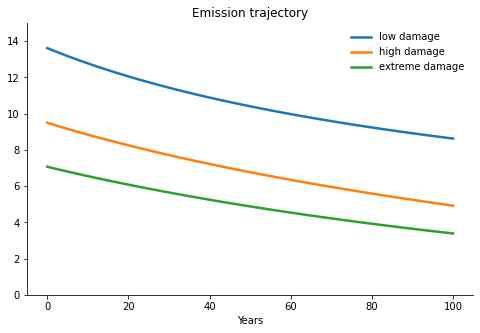

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(et_low, label='low damage', linewidth=2.5)
plt.plot(et_high, label='high damage', linewidth=2.5)
plt.plot(et_extreme, label='extreme damage', linewidth=2.5)
plt.ylim(0, 15)
plt.xlabel('Years')
plt.legend(frameon=False)
plt.title('Emission trajectory')

In [18]:
# 5. Plot SCC
# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

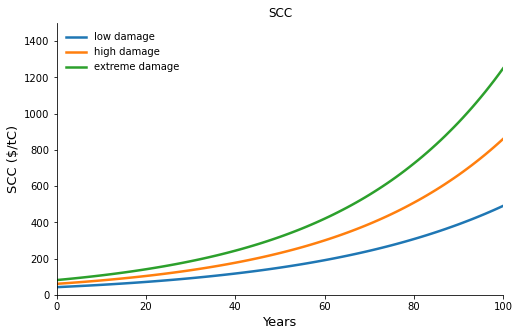

In [20]:
SCCt_low= η*(0.025)*Kt/((1.-η)*et_low) * 1000
SCCt_high = η*(0.025)*Kt/((1.-η)*et_high) * 1000
SCCt_extreme = η*(0.025)*Kt/((1.-η)*et_extreme) * 1000

plt.figure(figsize=(8, 5))
plt.plot(SCCt_low, label='low damage', linewidth=2.5)
plt.plot(SCCt_high, label='high damage', linewidth=2.5)
plt.plot(SCCt_extreme, label='extreme damage', linewidth=2.5)

plt.ylim(0, 1500)
plt.xlim(0, 100)
plt.xlabel('Years', fontsize=13)
plt.ylabel('SCC ($/tC)', fontsize=13)
plt.title('SCC')
plt.legend(frameon=False)